# Sentiment Analysis of Yahoo! Movie reviews

- Using Marc's thesis dataset (Chinese Yahoo Movie Reviews)
- Important Steps
  - Loading the CSV dataset
  - Tokenize into words (texts have been segmented)
  - Split train-test
  - One-hot encoding of texts
  - Define model
  - Train the model
  - Evaluate the model

## Setting Colab Environment

- Setting Spacy Language Model
  - For some reason, the Chiense language model is not available in the most recent spacy 2.4. Reinstall spacy 2.3 `!pip install spacy==2.3`
  - Download the language model using terminal `!spacy download zh_core_web_lg`
  - Restart the colab runtime
  - Ready to go!
- Install a package `skater`

In [1]:
!pip install spacy==2.3
!spacy download zh_core_web_lg
!pip install skater


✔ Download and installation successful
You can now load the model via spacy.load('zh_core_web_lg')


## Google Drive Access

- After running the code cell, visit the URL and copy-paste the code back here

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


## Loading Libraries

In [3]:
import pandas as pd
import numpy as np
import keras
import spacy
import gensim
from nltk.tokenize import WhitespaceTokenizer
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D, LSTM, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline, TransformerMixin
from sklearn.base import BaseEstimator
from skater.core.local_interpretation.lime.lime_text import LimeTextExplainer



## Loading Dataset

In [4]:
df = pd.read_csv('/content/gdrive/My Drive/ColabData/marc_movie_review_metadata.csv')

In [5]:
df.head()

,reviewID,title_CH,title_EN,genre,rating,reviews,reviews_sentiword_seg
0,Review_1,紫羅蘭永恆花園外傳－永遠與自動手記人偶－,Violet Evergarden - Eternity and the Auto Memo...,動畫,negative,唉，踩雷了，浪費時間，不推 唉，踩雷了，浪費時間，不推,唉 ， 踩 雷 了 ， 浪費 時間 ， 不 推 唉 ， 踩 雷 了 ， 浪費 時間 ， 不 推
1,Review_2,復仇者聯盟：終局之戰,Avengers: Endgame,動作_冒險,negative,片長三個小時，只有最後半小時能看，前面真的鋪陳太久，我旁邊的都看到打呼,片長 三個 小時 ， 只有 最後 半 小時 能 看 ， 前面 真的 鋪陳 太久 ， 我 旁邊...
2,Review_3,復仇者聯盟：終局之戰,Avengers: Endgame,動作_冒險,negative,史上之最，劇情拖太長，邊看邊想睡覺...... 1.浩克竟然學會跟旁人一起合照。 2.索爾...,史上 之 最 ， 劇情 拖 太長 ， 邊看邊 想 睡覺 . . . . . . 1. 浩克 ...
3,Review_4,復仇者聯盟：終局之戰,Avengers: Endgame,動作_冒險,negative,難看死ㄌ 難看死了 難看死ㄌ 看到睡著 拖戲拖很長 爛到爆,難看 死 ㄌ 難看 死 了 難看 死 ㄌ 看到 睡著 拖戲 拖 很長 爛 到 爆
4,Review_5,復仇者聯盟：終局之戰,Avengers: Endgame,動作_冒險,negative,連續三度睡著，真的演的太好睡了,連續 三度 睡著 ， 真的 演 的 太 好 睡 了


## Train-Test Split

In [ ]:

reviews = np.array(df['reviews_sentiword_seg'])
sentiments = np.array(df['rating'])

In [ ]:
reviews_train, reviews_test = train_test_split(reviews, test_size = 0.2, random_state=123)
sentiments_train, sentiments_test = train_test_split(sentiments, test_size=0.2, random_state=123)

In [ ]:
print(reviews[:10])
print(sentiments[:10])

['唉 ， 踩 雷 了 ， 浪費 時間 ， 不 推 唉 ， 踩 雷 了 ， 浪費 時間 ， 不 推'
 '片長 三個 小時 ， 只有 最後 半 小時 能 看 ， 前面 真的 鋪陳 太久 ， 我 旁邊 的 都 看到 打呼'
 '史上 之 最 ， 劇情 拖 太長 ， 邊看邊 想 睡覺 . . . . . . 1. 浩克 竟然 學會 跟 旁人 一起 合照 。 2. 索爾 住處 的 wifi 為什麼 不設 密碼 ？ 啊 我 究竟 是 看到 了 什麼 . . . . . . . . . . . . . . 這部 電影 ， 感覺 浪費 時間 ， 浪費 錢 . . . . . . . .'
 '難看 死 ㄌ 難看 死 了 難看 死 ㄌ 看到 睡著 拖戲 拖 很長 爛 到 爆' '連續 三度 睡著 ， 真的 演 的 太 好 睡 了'
 '一 整個 完全 看不懂 以前 以後 的 整個 後 前半段 都 在 閒話家常 後半段 像 看 了 一部 電玩 動 畫展 真的是 傻眼 美國隊長 為什麼 還 能 拿 槌子 了 浩克一 整個 以浩克 變身 在 聊天 完全 沒什麼 心情 起伏 一整 打哈欠 復仇 者 聯盟 之終 局 除夕 大團圓'
 '時間 長 , 真 難看 , 不知 為何 賣 座 這麼 好 , 浪費 我 半天 的 時間' '圈圈 叉叉 點 點點 。'
 '英雄片 的 劇情 ， 千篇一律 ， 沒什麼 看頭'
 '感覺 漫威 抄襲 了 DC ， 卻 來 嘲笑 DC ? ? ? 沒看 誰家 的 漫畫 ~ 但 所有 的 概念 卻 是 自 於 DC 電視劇 閃電俠 彩蛋 是 噹噹 噹噹 噹噹 ~ 我 都 歪 了 剪貼 片 嗎 ? ?']
['negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative']


## Data Transformation

- There are two versions of the review text data:
  - reviews_train: List of segmented texts from csv
  - reviews_train/test_tokens: List of word tokens of each text
- There are two versions of the sentiment labels:
  - sentiments_train/test_categorical: the numerical representation of the nominal variable for sentiment labels (e.g., positive = 1, negative = 0)
  - sentiments_train/test_onehot: the one-hot encoding version of the sentiment labels (e.g., positive = [0,1], negative = [1,0])

In [ ]:
## Text/Label Transformation
wt = WhitespaceTokenizer()
reviews_train_tokens = [wt.tokenize(text) for text in reviews_train]
reviews_train_tokens[0]
le = LabelEncoder()
sentiments_train_categorical = le.fit_transform(sentiments_train)
sentiments_train_onehot = keras.utils.to_categorical(sentiments_train_categorical, 2)


In [ ]:
reviews_test_tokens = [wt.tokenize(text) for text in reviews_test]
sentiments_test_categorical = le.fit_transform(sentiments_test)
sentiments_test_onehot = keras.utils.to_categorical(sentiments_test_categorical, 2)

## Model 1

- Four-Layered Fully Connected Neural Network 
- Self-trained Embeddings using skip-gram (based on the train data)

In [ ]:
print('Sentiment Class Label Map:', 
      dict(zip(le.classes_, le.transform(le.classes_))))

print('Sample Test Label Transformation:\n'+'='*35,
      '\nOriginal Labels:', sentiments_test[:3],
      '\nEncoded Labels:',sentiments_test_categorical[:3],
      '\nOne-hot Encodings:\n', sentiments_test_onehot[:3])

Sentiment Class Label Map: {'negative': 0, 'positive': 1}
Sample Test Label Transformation:
Original Labels: ['negative' 'positive' 'positive'] 
Encoded Labels: [0 1 1] 
One-hot Encodings:
 [[1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
%%time
## Training Word Embeddings
w2v_num_features = 300
w2v_model = gensim.models.Word2Vec(reviews_train_tokens,
                                   size=w2v_num_features,
                                   window=5,
                                   min_count=0,
                                   sg= 1, # 1 for skipgram, 0 for CBOW
                                   workers=16)

CPU times: user 5.79 s, sys: 44.3 ms, total: 5.84 s
Wall time: 3.87 s


In [ ]:
## This model uses the document word vector averaging scheme
## Use the average word vector representations to represent one document (movie reivew)

def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=reviews_train_tokens, model=w2v_model,
                                                     num_features=w2v_num_features)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=reviews_test_tokens, model=w2v_model,
                                                    num_features=w2v_num_features)

In [ ]:
print('Self-Trained Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)

Self-Trained Word2Vec model:> Train features shape: (2560, 300)  Test features shape: (640, 300)


In [ ]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, input_shape=(num_input_features,), kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization()) # improve  stability of the network.
    dnn_model.add(Activation('relu')) # relu better than sigmoid, to present vanishing gradient problem
    dnn_model.add(Dropout(0.2)) # prevents overfitting
    
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

## Plotting results
def plot(history):
    import matplotlib.pyplot as plt
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Epoch 1/100
24/24 [==============================] - 0s 13ms/step - loss: 0.5579 - accuracy: 0.7435 - val_loss: 0.6610 - val_accuracy: 0.7500
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 0.4831 - accuracy: 0.7830 - val_loss: 0.6512 - val_accuracy: 0.6680
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 0.4715 - accuracy: 0.7752 - val_loss: 0.6329 - val_accuracy: 0.6367
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 0.4646 - accuracy: 0.7943 - val_loss: 0.6606 - val_accuracy: 0.5273
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 0.4680 - accuracy: 0.7756 - val_loss: 0.6532 - val_accuracy: 0.5586
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 0.4533 - accuracy: 0.7778 - val_loss: 0.6284 - val_accuracy: 0.6094
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.4505 - accuracy: 0.7865 - val_loss: 0.5928 - val_accuracy: 0.6953
Epoch 8/100


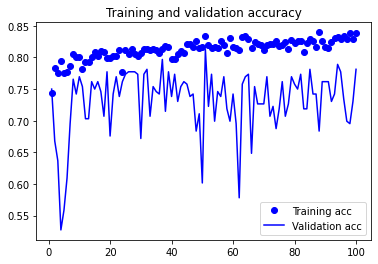

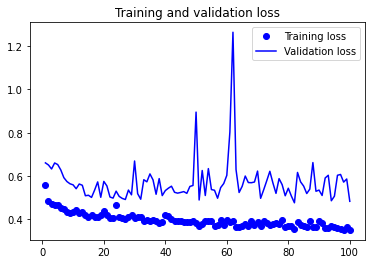

In [ ]:
w2v_num_features = 300
w2v_dnn = construct_deepnn_architecture(num_input_features=w2v_num_features)
batch_size = 100
history=w2v_dnn.fit(avg_wv_train_features, sentiments_train_onehot, epochs=100, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)
plot(history)

In [ ]:
# functions from Text Analytics with Python book
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=level_labels)) 
    print(cm_frame) 
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)
from sklearn import metrics

### Evaluation

In [ ]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred) 
display_model_performance_metrics(true_labels=sentiments_test, predicted_labels=predictions, 
                                      classes=['positive', 'negative']) 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Model Performance metrics:
------------------------------
Accuracy: 0.8031
Precision: 0.8088
Recall: 0.8031
F1 Score: 0.8017

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.85      0.72      0.78       312
    negative       0.77      0.88      0.82       328

    accuracy                           0.80       640
   macro avg       0.81      0.80      0.80       640
weighted avg       0.81      0.80      0.80       640


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive  


## Model 2

- Four-layered fully-connected neural network
- Using pretrained GloVe Chinese embeddings provided in spacy
- Install the `zh_core_web_lg` before using it (See the beginning of the code)
- Spacy is able to convert a word (text or sentence or word) into word embeddings

In [ ]:

nlp_vec = spacy.load('zh_core_web_lg', parse=False, tag=False, entity=False)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.927 seconds.
Prefix dict has been built successfully.


In [ ]:
## feature engineering with GloVe model
train_nlp = [nlp_vec(item) for item in reviews_train]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [nlp_vec(item) for item in reviews_test]
test_glove_features = np.array([item.vector for item in test_nlp])

In [ ]:
# nlp_vec('word').vector # convert a word into embeddings
# nlp_vec('this is a word').vector # convert a sentence into embeddings by taking averages of word embeddings

In [ ]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)
print('GloVe model:> Train features shape:', train_glove_features.shape, ' Test features shape:', test_glove_features.shape)

Word2Vec model:> Train features shape: (2560, 300)  Test features shape: (640, 300)
GloVe model:> Train features shape: (2560, 300)  Test features shape: (640, 300)


Epoch 1/100
24/24 [==============================] - 0s 12ms/step - loss: 0.5767 - accuracy: 0.7448 - val_loss: 0.5195 - val_accuracy: 0.7617
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 0.4051 - accuracy: 0.8286 - val_loss: 0.4664 - val_accuracy: 0.8125
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 0.3428 - accuracy: 0.8533 - val_loss: 0.5333 - val_accuracy: 0.7617
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 0.3227 - accuracy: 0.8681 - val_loss: 0.4930 - val_accuracy: 0.7734
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 0.2662 - accuracy: 0.8950 - val_loss: 0.5911 - val_accuracy: 0.7578
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 0.2319 - accuracy: 0.9032 - val_loss: 0.7137 - val_accuracy: 0.7070
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 0.2470 - accuracy: 0.8950 - val_loss: 0.8470 - val_accuracy: 0.6484
Epoch 8/100


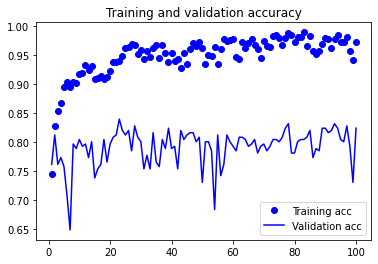

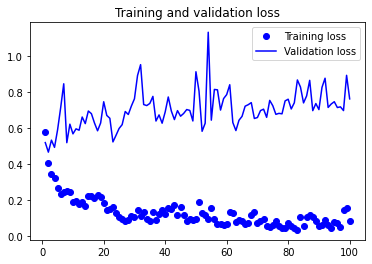

In [ ]:
w2v_num_features = 300
w2v_dnn_glove = construct_deepnn_architecture(num_input_features=w2v_num_features)
batch_size = 100
history2=w2v_dnn_glove.fit(train_glove_features, sentiments_train_onehot, epochs=100, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)
plot(history2)

### Evaluation

In [ ]:
y_pred = w2v_dnn_glove.predict_classes(test_glove_features)
predictions = le.inverse_transform(y_pred) 
display_model_performance_metrics(true_labels=sentiments_test, predicted_labels=predictions, 
                                      classes=['positive', 'negative']) 

Model Performance metrics:
------------------------------
Accuracy: 0.8375
Precision: 0.8391
Recall: 0.8375
F1 Score: 0.8371

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.86      0.79      0.83       312
    negative       0.82      0.88      0.85       328

    accuracy                           0.84       640
   macro avg       0.84      0.84      0.84       640
weighted avg       0.84      0.84      0.84       640


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive        248       64
        negative         40      288


## Model 3

- LSTM
- Self-trained embedding layer
- After the first few epochs, the model shows over-fitting problems

In [ ]:
print(reviews_train[0])
print(reviews_train_tokens[0])


 
 進去 看 之前 請 省思
['花', '了', '280', '塊', '看完', '這部', '才', '知道', '摁', '.', '.', '.', '還是', '拿', '去', '吃', '晚餐', '實際', '進去', '看', '之前', '請', '省思']


In [ ]:
## Prepare data for LSTM format

## Convert reviews/text_train_tokens into index

from collections import Counter

## Craete word freq list
token_counter = Counter([token for text in reviews_train_tokens for token in text])

## Create vocab index map (word2id)
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = len(vocab_map.values()) # np.max(list(vocab_map.values()))

## Two intersting index
vocab_map['PAD_INDEX'] = 0 # index for padding
vocab_map['OOV_INDEX'] = max_index+1 # index for OOV

vocab_size=len(vocab_map)

# progress report
print('Vocabulary Size:', vocab_size)
print('Examples of vocabulary map:',
      dict(list(vocab_map.items())[:20]))



Vocabulary Size: 9170
Examples of vocabulary map: {'花': 1, '了': 2, '280': 3, '塊': 4, '看完': 5, '這部': 6, '才': 7, '知道': 8, '摁': 9, '.': 10, '還是': 11, '拿': 12, '去': 13, '吃': 14, '晚餐': 15, '實際': 16, '進去': 17, '看': 18, '之前': 19, '請': 20}


In [ ]:
## Padding

from keras.preprocessing import sequence

## find the max text length of training
max_len = np.max([len(text) for text in reviews_train_tokens])

## Convert reviews_train_tokens into reviews_train_ids
reviews_train_ids = [[vocab_map[token] for token in text] for text in reviews_train_tokens]
reviews_test_ids = [[vocab_map[token] if vocab_map.get(token) else vocab_map['OOV_INDEX']
                     for token in text] for text in reviews_test_tokens]


## Padding reviews to the max_len
reviews_train_ids = sequence.pad_sequences(reviews_train_ids, maxlen=max_len)
reviews_test_ids = sequence.pad_sequences(reviews_test_ids, maxlen=max_len)

## Progress
print('Max Length of Review Texts:', max_len)
print('Train Review Shape:', reviews_train_ids.shape,
      '\nTest Review Shape:', reviews_test_ids.shape)

## LSTM uses the le.transform categorical version of labels

Max Length of Review Texts: 519
Train Review Shape: (2560, 519) 
Test Review Shape: (640, 519)


In [ ]:

EMBEDDING_DIM = 128
LSTM_DIM=64
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer="adam",
              metrics=['accuracy'])

batch_size=100
history3=model.fit(reviews_train_ids, sentiments_train_categorical,
          batch_size=batch_size,
          shuffle=True,
          validation_split=0.1,
          verbose=1,
          epochs=10)

Epoch 1/10
24/24 [==============================] - 47s 2s/step - loss: 0.6742 - accuracy: 0.6367 - val_loss: 0.6194 - val_accuracy: 0.7188
Epoch 2/10
24/24 [==============================] - 48s 2s/step - loss: 0.4787 - accuracy: 0.8307 - val_loss: 0.4147 - val_accuracy: 0.8359
Epoch 3/10
24/24 [==============================] - 49s 2s/step - loss: 0.2378 - accuracy: 0.9167 - val_loss: 0.4069 - val_accuracy: 0.8359
Epoch 4/10
24/24 [==============================] - 49s 2s/step - loss: 0.2149 - accuracy: 0.9332 - val_loss: 0.3721 - val_accuracy: 0.8477
Epoch 5/10
24/24 [==============================] - 49s 2s/step - loss: 0.1151 - accuracy: 0.9709 - val_loss: 0.3644 - val_accuracy: 0.8555
Epoch 6/10
24/24 [==============================] - 49s 2s/step - loss: 0.0611 - accuracy: 0.9848 - val_loss: 0.4086 - val_accuracy: 0.8555
Epoch 7/10
24/24 [==============================] - 48s 2s/step - loss: 0.0356 - accuracy: 0.9931 - val_loss: 0.4482 - val_accuracy: 0.8516
Epoch 8/10
24/24 [==

In [ ]:
model.save_weights('/content/gdrive/My Drive/ColabData/marc-sent-analysis-lstm-self.h5')

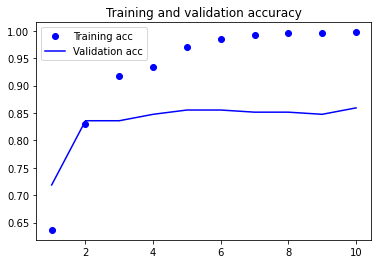

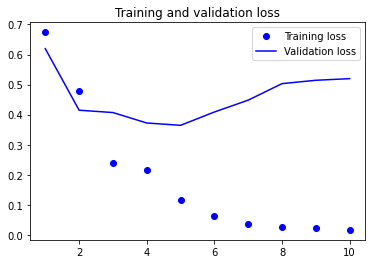

In [ ]:
plot(history3)

### Evaluation

In [ ]:
y_pred = model.predict_classes(reviews_test_ids)
predictions = le.inverse_transform(y_pred) 
display_model_performance_metrics(true_labels=sentiments_test, predicted_labels=predictions, 
                                      classes=['positive', 'negative']) 

Model Performance metrics:
------------------------------
Accuracy: 0.8719
Precision: 0.873
Recall: 0.8719
F1 Score: 0.8719

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.85      0.89      0.87       312
    negative       0.89      0.85      0.87       328

    accuracy                           0.87       640
   macro avg       0.87      0.87      0.87       640
weighted avg       0.87      0.87      0.87       640


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive        279       33
        negative         49      279


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Model 4

- LSTM
- Using pre-trained word embeddings (GloVe)

In [ ]:
## Extract spacy GloVe word vector

glove_word_vectors = nlp_vec.vocab.vectors
print('Spacy GloVe word vectors Shape: (vocab_size, embedding_dim)',glove_word_vectors.shape   )

Spacy GloVe word vectors Shape: (vocab_size, embedding_dim) (500000, 300)


In [ ]:
# vocab_map['好看']
nlp_vec('好看').vector
type(vocab_map)

dict

In [ ]:
## Prepare GloVe Word Embedding Matrix for training
embedding_dim_glove = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim_glove))
for w, i in vocab_map.items():
  cur_w_embedding_vector = nlp_vec(w).vector
  if cur_w_embedding_vector is not None:
    embedding_matrix[i]=cur_w_embedding_vector

print('Glove embedding layer shape for training:', embedding_matrix.shape)

Glove embedding layer shape for training: (9170, 300)


In [ ]:
EMBEDDING_DIM = 128
LSTM_DIM=64
model4 = Sequential()
model4.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim_glove, input_length=max_len))
model4.add(SpatialDropout1D(0.2))
model4.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(1, activation="sigmoid"))
model4.compile(loss='binary_crossentropy', optimizer="adam",
              metrics=['accuracy'])
model4.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 519, 300)          2751000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 519, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 2,844,505
Trainable params: 2,844,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Set the embedding layer
## And freeze this layer

model4.layers[0].set_weights([embedding_matrix])
model4.layers[0].trainable=False

In [ ]:
batch_size=100
history4=model4.fit(reviews_train_ids, sentiments_train_categorical,
          batch_size=batch_size,
          shuffle=True,
          validation_split=0.1,
          verbose=1,
          epochs=10)

Epoch 1/10
24/24 [==============================] - 49s 2s/step - loss: 0.6573 - accuracy: 0.6020 - val_loss: 0.5884 - val_accuracy: 0.6992
Epoch 2/10
24/24 [==============================] - 48s 2s/step - loss: 0.5994 - accuracy: 0.6732 - val_loss: 0.5370 - val_accuracy: 0.7344
Epoch 3/10
24/24 [==============================] - 49s 2s/step - loss: 0.5402 - accuracy: 0.7339 - val_loss: 0.4913 - val_accuracy: 0.7578
Epoch 4/10
24/24 [==============================] - 49s 2s/step - loss: 0.4922 - accuracy: 0.7652 - val_loss: 0.4665 - val_accuracy: 0.7617
Epoch 5/10
24/24 [==============================] - 49s 2s/step - loss: 0.4442 - accuracy: 0.7947 - val_loss: 0.4138 - val_accuracy: 0.8125
Epoch 6/10
24/24 [==============================] - 49s 2s/step - loss: 0.4030 - accuracy: 0.8199 - val_loss: 0.3970 - val_accuracy: 0.8398
Epoch 7/10
24/24 [==============================] - 50s 2s/step - loss: 0.3559 - accuracy: 0.8494 - val_loss: 0.4078 - val_accuracy: 0.8281
Epoch 8/10
24/24 [==

In [ ]:
model4.save_weights('/content/gdrive/My Drive/ColabData/marc-sent-analysis-lstm-glove.h5')

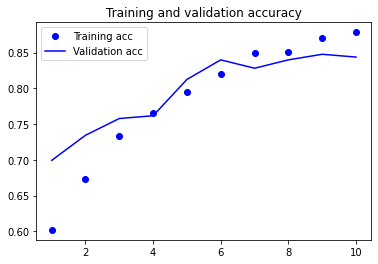

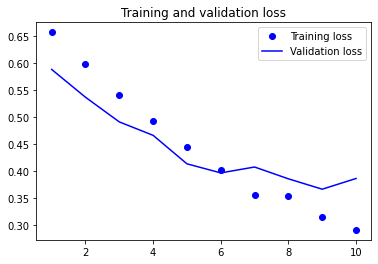

In [ ]:
plot(history4)

### Evaluation

In [ ]:
y_pred = model4.predict_classes(reviews_test_ids)
predictions = le.inverse_transform(y_pred) 
display_model_performance_metrics(true_labels=sentiments_test, predicted_labels=predictions, 
                                      classes=['positive', 'negative']) 

Model Performance metrics:
------------------------------
Accuracy: 0.8391
Precision: 0.8394
Recall: 0.8391
F1 Score: 0.8391

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.83      0.85      0.84       312
    negative       0.85      0.83      0.84       328

    accuracy                           0.84       640
   macro avg       0.84      0.84      0.84       640
weighted avg       0.84      0.84      0.84       640


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive        265       47
        negative         56      272


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Interpreting Models

### Preparing Data

In [ ]:
#load df
df = pd.read_csv('/content/gdrive/My Drive/ColabData/marc_movie_review_metadata.csv')
# split train-test

# reviews = np.array(df['reviews_sentiword_seg'])
# sentiments = np.array(df['rating'])

reviews = df['reviews_sentiword_seg'].values
sentiments = df['rating'].values
reviews_train, reviews_test = train_test_split(reviews, test_size = 0.2, random_state=123)
sentiments_train, sentiments_test = train_test_split(sentiments, test_size=0.2, random_state=123)
## Text/Label Transformation
wt = WhitespaceTokenizer()
reviews_train_tokens = [wt.tokenize(text) for text in reviews_train]
reviews_train_tokens[0]
le = LabelEncoder()
sentiments_train_categorical = le.fit_transform(sentiments_train)
sentiments_train_onehot = keras.utils.to_categorical(sentiments_train_categorical, 2)
reviews_test_tokens = [wt.tokenize(text) for text in reviews_test]
sentiments_test_categorical = le.fit_transform(sentiments_test)
sentiments_test_onehot = keras.utils.to_categorical(sentiments_test_categorical, 2)


### Train Data Parameters

- vocabulary size
- max text length

In [ ]:
reviews_train_tokens = [r.split(" ") for r in reviews_train]
maxlen_train = print(np.max([len(t) for t in reviews_train_tokens]))
vocab=set([token for text in reviews_train_tokens for token in text])
vocab_size_train=len(vocab)
print(vocab_size)

563
9170


### Building Pipeline for New Test Data

In [ ]:
vocab_size=vocab_size_train
maxlen=maxlen_train

## Building pipeline

# model.load_weights('/content/gdrive/My Drive/ColabData/marc-sent-analysis-lstm-glove.h5')



#Building Text Classification Pipeline

## reviews_test_tokens
## reviews_test_ids
## reviews_test


class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)
                             #filters='《!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ',
                            # split=' ')

class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)



#lstm_pipeline = make_pipeline(sequencer, model4)
#classes = ['negative', 'positive' ]



In [ ]:
sequencer.fit(reviews_train)
x1=sequencer.transform(reviews_train)
padder.fit(x1)
x2=padder.transform(x1)
# print(x1.shape)
# print(x2.shape)
# print(x1[1,])
# print(x2[1,])
#print(x2[0])
word_index=sequencer.word_index
index_word = dict([(id, w) for (w, id) in word_index.items()])
index_word[1]
print(''.join([index_word.get(id, '') for id in list(x2[5])]))
print(reviews_test[5])
print(len(index_word))
print(vocab_size)
## Extract spacy GloVe word vector
nlp_vec = spacy.load('zh_core_web_lg', parse=False, tag=False, entity=False)
glove_word_vectors = nlp_vec.vocab.vectors
print('Spacy GloVe word vectors Shape: (vocab_size, embedding_dim)',glove_word_vectors.shape   )
# Prepare GloVe Word Embedding Matrix for training
embedding_dim_glove = 300
embedding_matrix = np.zeros((vocab_size+1, embedding_dim_glove))
for w, i in word_index.items():
  cur_w_embedding_vector = nlp_vec(w).vector
  if cur_w_embedding_vector is not None:
    embedding_matrix[i]=cur_w_embedding_vector

print('Glove embedding layer shape for training:', embedding_matrix.shape)

每次快選舉某黨利用這個議題操作，現在電影也來膩不膩啊
認真 劇情 普通 ， 最近 幾部 電影 大 咖 都 被 劇本 耽誤 杜立德 也是 虧一波
9176
9267
Spacy GloVe word vectors Shape: (vocab_size, embedding_dim) (500000, 300)
Glove embedding layer shape for training: (9268, 300)


In [ ]:

max_features = vocab_size+1
def create_model(max_features, embedding_dim, max_len, lstm_dim, embedding_matrix):
  model4 = Sequential()
  model4.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_len))
  model4.add(SpatialDropout1D(0.2))
  model4.add(LSTM(lstm_dim, dropout=0.2, recurrent_dropout=0.2))
  model4.add(Dense(1, activation="sigmoid"))
  model4.compile(loss='binary_crossentropy', optimizer="adam",
                metrics=['accuracy'])
  model4.layers[0].set_weights([embedding_matrix])
  model4.layers[0].trainable=False  
  return model4

from keras.wrappers.scikit_learn import KerasClassifier
sklearn_lstm = KerasClassifier(build_fn=create_model,
                               epochs=10,
                               batch_size=100,
                               verbose=1,
                               max_features=max_features,
                               embedding_dim=300,
                               max_len=maxlen,
                               lstm_dim=64,
                               embedding_matrix = embedding_matrix)

In [ ]:
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

In [ ]:
pipeline.fit(reviews_train, sentiments_train)

Epoch 1/10
26/26 [==============================] - 53s 2s/step - loss: 0.6667 - accuracy: 0.5859
Epoch 2/10
26/26 [==============================] - 54s 2s/step - loss: 0.5799 - accuracy: 0.6980
Epoch 3/10
26/26 [==============================] - 55s 2s/step - loss: 0.5031 - accuracy: 0.7625
Epoch 4/10
26/26 [==============================] - 52s 2s/step - loss: 0.4253 - accuracy: 0.8137
Epoch 5/10
26/26 [==============================] - 52s 2s/step - loss: 0.3771 - accuracy: 0.8273
Epoch 6/10
26/26 [==============================] - 54s 2s/step - loss: 0.3394 - accuracy: 0.8562
Epoch 7/10
26/26 [==============================] - 55s 2s/step - loss: 0.3121 - accuracy: 0.8719
Epoch 8/10
26/26 [==============================] - 54s 2s/step - loss: 0.2787 - accuracy: 0.8883
Epoch 9/10
26/26 [==============================] - 54s 2s/step - loss: 0.2467 - accuracy: 0.9066
Epoch 10/10
26/26 [==============================] - 53s 2s/step - loss: 0.2263 - accuracy: 0.9109


Pipeline(memory=None,
         steps=[('textstosequences', TextsToSequences()),
                ('padder', Padder(maxlen=None)),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f28c2b05da0>)],
         verbose=False)

### Save Fitted Pipeline

In [ ]:
# from sklearn.externals import joblib
# print(pipeline.named_steps.keys())
# # Save the Keras model first: /content/gdrive/My Drive/ColabData/
# pipeline.named_steps['kerasclassifier'].model.save('/content/gdrive/My Drive/ColabData/marc-keras_model.h5')

# # This hack allows us to save the sklearn pipeline:
# pipeline.named_steps['kerasclassifier'].model = None

# # Finally, save the pipeline:
# joblib.dump(pipeline, '/content/gdrive/My Drive/ColabData/marc-sklearn_pipeline.pkl')

### Prediction

### Load Trained Model

In [ ]:
from sklearn.externals import joblib
from keras.models import load_model
# Load the pipeline first:
pipeline = joblib.load('/content/gdrive/My Drive/ColabData/marc-sklearn_pipeline.pkl')

# Then, load the Keras model:
pipeline.named_steps['kerasclassifier'].model = load_model('/content/gdrive/My Drive/ColabData/marc-keras_model.h5')

#y_pred = pipeline.predict(reviews_test)
#display_model_performance_metrics(true_labels=sentiments_test, predicted_labels=y_pred, 
#                                      classes=['positive', 'negative']) 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn import metrics
print('Computing predictions on test set...')
y_preds = pipeline.predict(reviews_test)

print('Test accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, sentiments_test)))

Computing predictions on test set...
7/7 [==============================] - 1s 87ms/step
Test accuracy: 86.72 %


### Interpretation

- Using LIME to interpret the importance of the features in relatio to the model prediction
- Identify important words that may have great contribution to the model prediction

#### Version 1

- Based on [LIME of words: interpreting Recurrent Neural Networks predictions](https://data4thought.com/deep-lime.html)

In [ ]:
import textwrap
# We choose a sample from test set
idx = 100
text_sample = reviews_test[idx]
class_names = ['negative', 'positive']

print('Review ID-{}:'.format(idx))
print('-'*50)
print('Review Text:\n', textwrap.fill(text_sample,40))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('Probability(negative) =', pipeline.predict_proba([text_sample])[0,0])
print('Predicted class: %s' % pipeline.predict([text_sample]))
print('True class: %s' % sentiments_test[idx])

Review ID-100:
--------------------------------------------------
Review Text:
 帶著 勇氣 , 戴上 口罩 進 了 電影院 , 看完 感覺 這跟本 就是 一部
想 靠 「 唐 老 大 」 的 臉 來 賣 票 的 電影 , 真心 覺得 好
失望 ! ~
--------------------------------------------------
Instructions for updating:
Please use `model.predict()` instead.
1/1 [==============================] - 0s 4ms/step
Probability(positive) = 0.18001655
1/1 [==============================] - 0s 3ms/step
Probability(negative) = 0.8199835
1/1 [==============================] - 0s 3ms/step
Predicted class: [['negative']]
True class: negative


In [ ]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

#import matplotlib as plt
matplotlib.rcParams['figure.dpi']=300
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, 
                                         pipeline.predict_proba, 
                                         num_features=10)
explanation.show_in_notebook(text=True)


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


50/50 [==============================] - 1s 10ms/step


OrderedDict([('失望', -0.2863666861195715), ('帶著', 0.15380635064510456), ('勇氣', 0.1538045345455234), ('覺得', -0.15302636489773194), ('的', 0.14963577391558058), ('好', 0.12208134957754466), ('靠', -0.12110649075811704), ('賣', -0.10764389018128104), ('電影', -0.08979260216193646), ('臉', -0.07214967224894779)])
Chinese Font Name: Source Han Sans


findfont: Font family ['Source Han Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Source Han Sans'] not found. Falling back to DejaVu Sans.


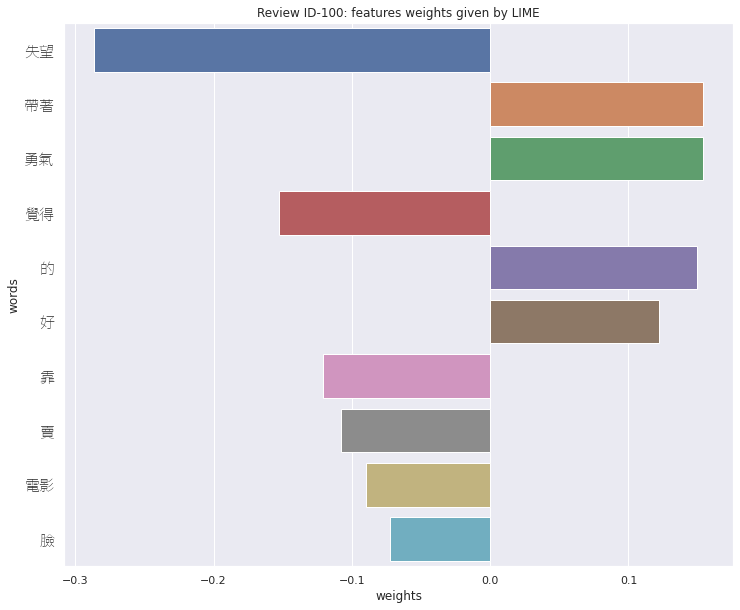

In [ ]:

weights = OrderedDict(explanation.as_list())

print(weights)
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

## Chinese fonts


def getChineseFont(size=15):  
    return matplotlib.font_manager.FontProperties(
        fname='/content/gdrive/My Drive/ColabData/SourceHanSans.ttc',size=size)  

print('Chinese Font Name:', getChineseFont().get_name())
sns.set(font=getChineseFont().get_name())
#sns.set_style('whitegrid',{'font.sans-serif':["Source Han Sans"]})
plt.figure(figsize=(12, 10))

sns.barplot(x="weights", y="words", data=lime_weights);
#sns.despine(left=True, bottom=True)
plt.yticks(rotation=0, FontProperties=getChineseFont())
plt.title('Review ID-{}: features weights given by LIME'.format(idx));

In [ ]:
# !wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
# !mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.6/dist-packages/matplotlib//mpl-data/fonts/ttf

#### Version 2

- Based on Text Analytics with Python Ch 9
- The `lime` on Colab is outdated. Re-install the most recent `lime` to make sure that Chinese texts pop out properly.

In [ ]:
# pipeline.predict_proba(reviews_test[:1])


In [ ]:
from skater.core.local_interpretation.lime.lime_text import LimeTextExplainer as LimeTextExplainer2
classes=pipeline.classes_


explainer2 = LimeTextExplainer2(class_names=classes)
def interpret_classification_model_prediction(doc_index, norm_corpus, corpus, 
                                              prediction_labels, explainer_obj):
    # display model prediction and actual sentiments
    print("Test document index: {index}\nActual sentiment: {actual}\nPredicted sentiment: {predicted}"
      .format(index=doc_index, actual=prediction_labels[doc_index],
              predicted=pipeline.predict([norm_corpus[doc_index]])))
    # display actual review content
    print("\nReview:", corpus[doc_index])
    # display prediction probabilities
    print("\nModel Prediction Probabilities:")
    for probs in zip(classes, pipeline.predict_proba([norm_corpus[doc_index]])[0]):
        print(probs)
    # display model prediction interpretation
    exp = explainer.explain_instance(norm_corpus[doc_index], 
                                     pipeline.predict_proba, num_features=10, 
                                     labels=[1])
    exp.show_in_notebook(text=True)

In [ ]:
import lime
!pip install lime

In [ ]:
doc_index = 100 
interpret_classification_model_prediction(doc_index=doc_index, norm_corpus=reviews_test,
                                         corpus=reviews_test, 
                                          prediction_labels=sentiments_test,
                                          explainer_obj = explainer2)

1/1 [==============================] - 0s 3ms/step
Test document index: 100
Actual sentiment: negative
Predicted sentiment: [['negative']]

Review: 帶著 勇氣 , 戴上 口罩 進 了 電影院 , 看完 感覺 這跟本 就是 一部 想 靠 「 唐 老 大 」 的 臉 來 賣 票 的 電影 , 真心 覺得 好 失望 ! ~

Model Prediction Probabilities:
1/1 [==============================] - 0s 1ms/step
('negative', 0.8199835)
('positive', 0.18001655)


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


50/50 [==============================] - 0s 9ms/step
